# Ensemble - CBAM

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow_addons as tfa

from glob import glob
from tqdm import tqdm

import cv2

from imgaug import augmenters as iaa
import imgaug as ia

import argparse
import wandb
from wandb.keras import WandbCallback
wandb.init(project="DACON_235896", name="Ensemble")

parser = argparse.ArgumentParser(description='Ensemble')
parser.add_argument('--resize_size', default=224, type=int)
parser.add_argument('--randaugment_n', default=3, type=int)
parser.add_argument('--randaugment_m', default=7, type=int)
parser.add_argument('--optimizer', default="sgd", type=str) # sgd or adam
parser.add_argument('--learning_rate', default=0.01, type=float)
parser.add_argument('--batch_size', default=128, type=int)
parser.add_argument('--epochs', default=200, type=int)
parser.add_argument('--n_splits', default=10, type=int)
parser.add_argument('--seed', default=1011, type=int)
args = parser.parse_args('')

wandb.config.update(args)

resize_size=args.resize_size
BATCH_SIZE=args.batch_size
EPOCHS=args.epochs
N_SPLITS=args.n_splits
SEED=args.seed

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    ia.seed(seed)

set_seeds()

wandb: Currently logged in as: gnoeyheat (use `wandb login --relogin` to force relogin)


## Preprocessing

In [2]:
def img_load(path):
    img = cv2.imread(path)[:,:,::-1]
    img = cv2.resize(img, (resize_size, resize_size))
    return img

X = np.array([img_load(i) for i in tqdm(glob('data/train/*.png'))])
X_test = np.array([img_load(i) for i in tqdm(glob('data/test/*.png'))])

y = pd.read_csv("data/train.csv")["label"]
y_encoder = {key : value for key, value in zip(np.unique(y), range(len(np.unique(y))))}
y = np.array([y_encoder[k] for k in y])

X.shape, X_test.shape, y.shape, X.dtype

100%|███████████████████████████████████████████████████████████████████████████████| 215/215 [00:00<00:00, 348.11it/s]


((858, 224, 224, 3), (215, 224, 224, 3), (858,), dtype('uint8'))

In [3]:
pd.read_csv("data/train.csv")["label"].value_counts()

2       83
4       83
10-1    82
7       82
8       79
9       79
5       79
6       79
1       79
3       77
10-2    56
Name: label, dtype: int64

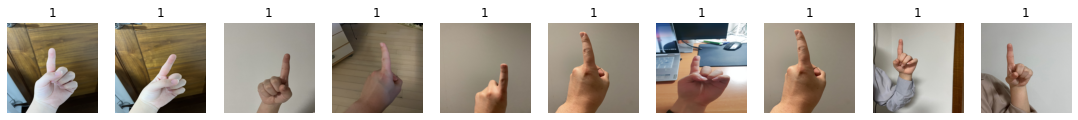

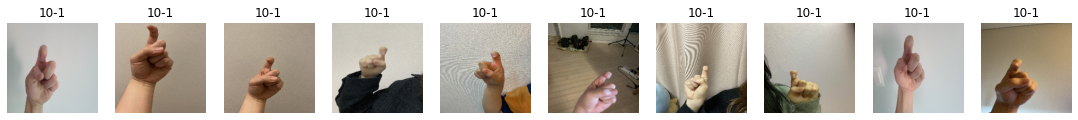

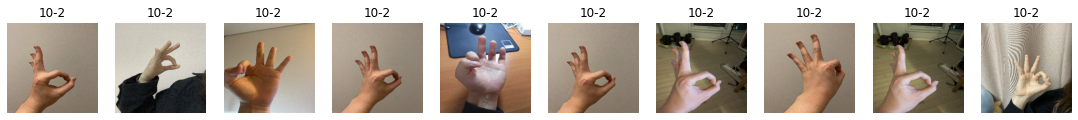

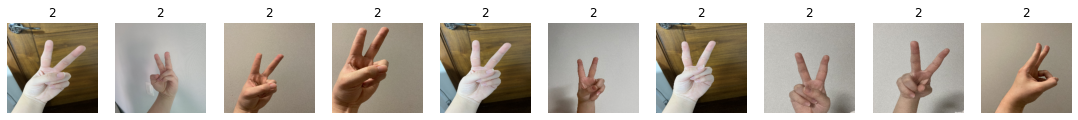

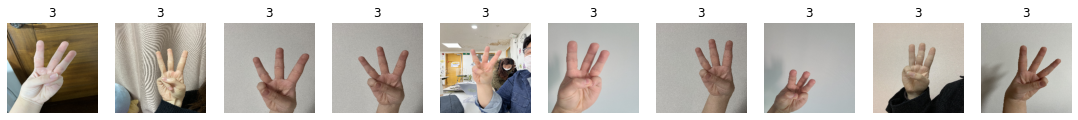

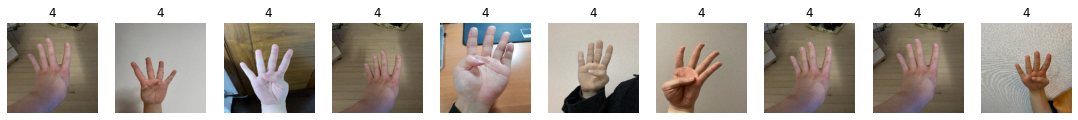

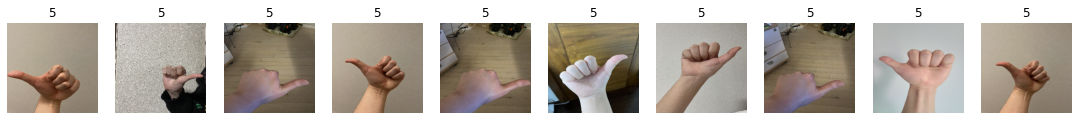

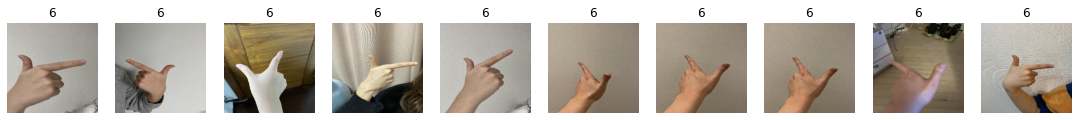

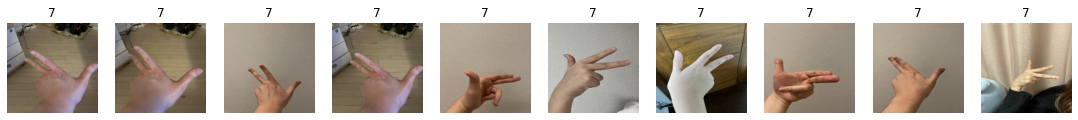

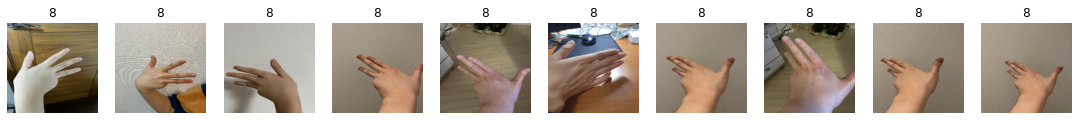

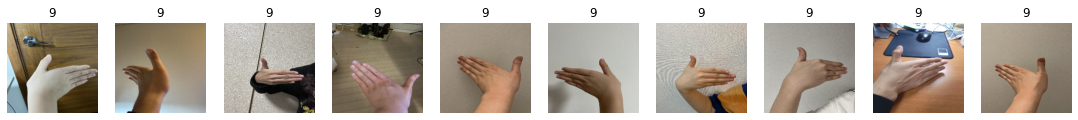

In [4]:
for k, v in y_encoder.items():
    plt.figure(figsize=(21,20))
    for i in range(10):
        plt.subplot(1, 11, i+1)
        plt.imshow(X[y==v][i])
        plt.title(k)
        plt.axis("off")
    plt.show()

## Modelling

### Attention Modules

In [5]:
def se_block(input_feature, ratio=8):
    
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]
    
    se_feature = layers.GlobalAveragePooling2D()(input_feature)
    se_feature = layers.Reshape((1, 1, channel))(se_feature)
    se_feature = layers.Dense(channel // ratio,
                              activation='relu',
                              kernel_initializer='he_normal',
                              use_bias=True,
                              bias_initializer='zeros')(se_feature)
    se_feature = layers.Dense(channel,
                              activation='sigmoid',
                              kernel_initializer='he_normal',
                              use_bias=True,
                              bias_initializer='zeros')(se_feature)
    
    if K.image_data_format() == 'channels_first':
        se_feature = layers.Permute((3, 1, 2))(se_feature)
        
    se_feature = layers.multiply([input_feature, se_feature])
    
    return se_feature


def cbam_block(cbam_feature, ratio=8):
    
    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    
    return cbam_feature


def channel_attention(input_feature, ratio=8):
    
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]
    
    shared_layer_one = layers.Dense(channel//ratio,
                                    activation='relu',
                                    kernel_initializer='he_normal',
                                    use_bias=True,
                                    bias_initializer='zeros')
    shared_layer_two = layers.Dense(channel,
                                    kernel_initializer='he_normal',
                                    use_bias=True,
                                    bias_initializer='zeros')

    avg_pool = layers.GlobalAveragePooling2D()(input_feature)
    avg_pool = layers.Reshape((1,1,channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)
    
    max_pool = layers.GlobalMaxPooling2D()(input_feature)
    max_pool = layers.Reshape((1,1,channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)
    
    cbam_feature = layers.Add()([avg_pool,max_pool])
    cbam_feature = layers.Activation('sigmoid')(cbam_feature)
    
    if K.image_data_format() == "channels_first":
        cbam_feature = layers.Permute((3, 1, 2))(cbam_feature)
        
    return layers.multiply([input_feature, cbam_feature])


def spatial_attention(input_feature):
    
    kernel_size = 7
    
    if K.image_data_format() == "channels_first":
        channel = input_feature.shape[1]
        cbam_feature = layers.Permute((2,3,1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature
        
    avg_pool = layers.Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    max_pool = layers.Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    concat = layers.Concatenate(axis=3)([avg_pool, max_pool])
    cbam_feature = layers.Conv2D(filters = 1,
                                 kernel_size=kernel_size,
                                 strides=1,
                                 padding='same',
                                 activation='sigmoid',
                                 kernel_initializer='he_normal',
                                 use_bias=False)(concat)
    
    if K.image_data_format() == "channels_first":
        cbam_feature = layers.Permute((3, 1, 2))(cbam_feature)
        
    return layers.multiply([input_feature, cbam_feature])

### Model

In [6]:
def cbam(activation='relu'):

    inp = tf.keras.Input(shape=(resize_size, resize_size, 3))
    x = layers.Rescaling(1./255)(inp)

    x = layers.Conv2D(32, 3, 1, "same", kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Conv2D(32, 3, 1, "same", kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = cbam_block(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, 1, "same", kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Conv2D(64, 3, 1, "same", kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = cbam_block(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, 1, "same", kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Conv2D(128, 3, 1, "same", kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = cbam_block(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(256, 3, 1, "same", kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Conv2D(256, 3, 1, "same", kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = cbam_block(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(512, 3, 1, "same", kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Conv2D(512, 3, 1, "same", kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = cbam_block(x)

    x = layers.Conv2D(1024, 3, 1, "same", kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Conv2D(1024, 3, 1, "same", kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = cbam_block(x)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(256, activation=activation)(x)
    x = layers.Dense(64, activation=activation)(x)
    oup = layers.Dense(len(np.unique(y)), activation="softmax")(x)
    model = tf.keras.Model(inputs=inp, outputs=oup)
    
    return model

### Augmentation

In [7]:
rand_aug = iaa.RandAugment(n=args.randaugment_n, m=args.randaugment_m)

def augment(images):
    images = tf.cast(images, tf.uint8)
    return rand_aug(images=images.numpy())

In [8]:
def tta(model, imgs):
    tta_pred=[]
    tta_pred.append(model.predict(imgs))
    tta_pred.append(model.predict(imgs[:,:,::-1]))
    return np.mean(tta_pred, axis=0)

## Training

Epoch 1/200
7/7 [==============================] - ETA: 0s - loss: 2.3992 - accuracy: 0.0946

C:\Users\Taehyeong\anaconda3\envs\DACON_tf\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


7/7 [==============================] - 26s 1s/step - loss: 2.3992 - accuracy: 0.0946 - val_loss: 2.3975 - val_accuracy: 0.0930 - _timestamp: 1653631241.0000 - _runtime: 53.0000
Epoch 2/200
7/7 [==============================] - 7s 719ms/step - loss: 2.3978 - accuracy: 0.0972 - val_loss: 2.3970 - val_accuracy: 0.0930 - _timestamp: 1653631248.0000 - _runtime: 60.0000
Epoch 3/200
7/7 [==============================] - 7s 720ms/step - loss: 2.3955 - accuracy: 0.0920 - val_loss: 2.3966 - val_accuracy: 0.0930 - _timestamp: 1653631255.0000 - _runtime: 67.0000
Epoch 4/200
7/7 [==============================] - 7s 713ms/step - loss: 2.3959 - accuracy: 0.1049 - val_loss: 2.3966 - val_accuracy: 0.0930 - _timestamp: 1653631262.0000 - _runtime: 74.0000
Epoch 5/200
7/7 [==============================] - 5s 435ms/step - loss: 2.3961 - accuracy: 0.0907 - val_loss: 2.3969 - val_accuracy: 0.0930 - _timestamp: 1653631268.0000 - _runtime: 80.0000
Epoch 6/200
7/7 [==============================] - 5s 436ms

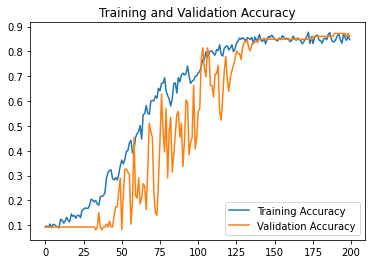

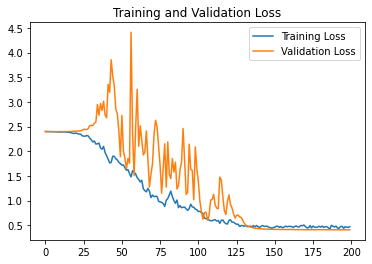

Epoch 1/200
7/7 [==============================] - 13s 801ms/step - loss: 2.3966 - accuracy: 0.0946 - val_loss: 2.3975 - val_accuracy: 0.0930 - _timestamp: 1653632425.0000 - _runtime: 1237.0000
Epoch 2/200
7/7 [==============================] - 6s 594ms/step - loss: 2.3959 - accuracy: 0.1036 - val_loss: 2.3974 - val_accuracy: 0.0930 - _timestamp: 1653632432.0000 - _runtime: 1244.0000
Epoch 3/200
7/7 [==============================] - 6s 595ms/step - loss: 2.3952 - accuracy: 0.0984 - val_loss: 2.3972 - val_accuracy: 0.0930 - _timestamp: 1653632438.0000 - _runtime: 1250.0000
Epoch 4/200
7/7 [==============================] - 5s 451ms/step - loss: 2.3949 - accuracy: 0.0959 - val_loss: 2.3973 - val_accuracy: 0.0930 - _timestamp: 1653632443.0000 - _runtime: 1255.0000
Epoch 5/200
7/7 [==============================] - 5s 444ms/step - loss: 2.3952 - accuracy: 0.0907 - val_loss: 2.3976 - val_accuracy: 0.0930 - _timestamp: 1653632449.0000 - _runtime: 1261.0000
Epoch 6/200
7/7 [=================

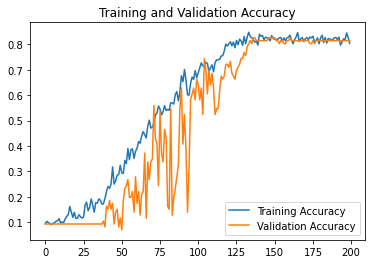

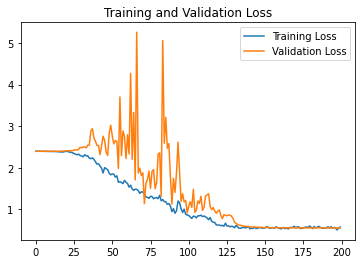

Epoch 1/200
7/7 [==============================] - 13s 870ms/step - loss: 2.3985 - accuracy: 0.0946 - val_loss: 2.3976 - val_accuracy: 0.0930 - _timestamp: 1653633572.0000 - _runtime: 2384.0000
Epoch 2/200
7/7 [==============================] - 7s 601ms/step - loss: 2.4022 - accuracy: 0.0881 - val_loss: 2.3972 - val_accuracy: 0.0930 - _timestamp: 1653633579.0000 - _runtime: 2391.0000
Epoch 3/200
7/7 [==============================] - 7s 616ms/step - loss: 2.4058 - accuracy: 0.1036 - val_loss: 2.3969 - val_accuracy: 0.0930 - _timestamp: 1653633585.0000 - _runtime: 2397.0000
Epoch 4/200
7/7 [==============================] - 5s 471ms/step - loss: 2.4046 - accuracy: 0.0855 - val_loss: 2.3970 - val_accuracy: 0.0930 - _timestamp: 1653633590.0000 - _runtime: 2402.0000
Epoch 5/200
7/7 [==============================] - 5s 462ms/step - loss: 2.4030 - accuracy: 0.0972 - val_loss: 2.3972 - val_accuracy: 0.0930 - _timestamp: 1653633596.0000 - _runtime: 2408.0000
Epoch 6/200
7/7 [=================

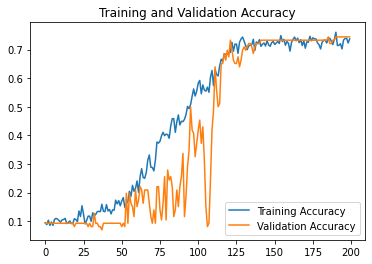

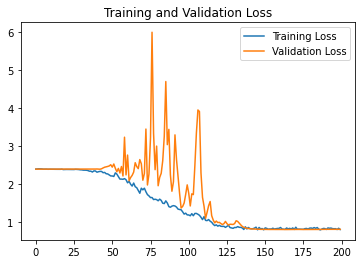

Epoch 1/200
7/7 [==============================] - 13s 784ms/step - loss: 2.3976 - accuracy: 0.0946 - val_loss: 2.3976 - val_accuracy: 0.0930 - _timestamp: 1653634761.0000 - _runtime: 3573.0000
Epoch 2/200
7/7 [==============================] - 6s 624ms/step - loss: 2.3984 - accuracy: 0.0933 - val_loss: 2.3972 - val_accuracy: 0.0930 - _timestamp: 1653634768.0000 - _runtime: 3580.0000
Epoch 3/200
7/7 [==============================] - 7s 594ms/step - loss: 2.4022 - accuracy: 0.1075 - val_loss: 2.3968 - val_accuracy: 0.0930 - _timestamp: 1653634774.0000 - _runtime: 3586.0000
Epoch 4/200
7/7 [==============================] - 7s 586ms/step - loss: 2.3992 - accuracy: 0.0997 - val_loss: 2.3965 - val_accuracy: 0.0930 - _timestamp: 1653634781.0000 - _runtime: 3593.0000
Epoch 5/200
7/7 [==============================] - 7s 616ms/step - loss: 2.3949 - accuracy: 0.0984 - val_loss: 2.3964 - val_accuracy: 0.0930 - _timestamp: 1653634788.0000 - _runtime: 3600.0000
Epoch 6/200
7/7 [=================

KeyboardInterrupt: 

In [9]:
idx=0
pred_ensemble=[]

skf = StratifiedKFold(n_splits=N_SPLITS)
for train_index, val_index in skf.split(X, y):
    
    idx+=1
    
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    train_ds = (
        tf.data.Dataset.from_tensor_slices((X_train, y_train))
        .shuffle(len(X_train))
        .batch(BATCH_SIZE)
        .map(lambda x, y: (tf.py_function(augment, [x], [tf.float32])[0], y),
             num_parallel_calls=tf.data.experimental.AUTOTUNE)
        .prefetch(tf.data.experimental.AUTOTUNE)
    )

    val_ds = (
        tf.data.Dataset.from_tensor_slices((X_val, y_val))
        .batch(BATCH_SIZE)
        .prefetch(tf.data.experimental.AUTOTUNE)
    )

    model = cbam()
    
    lr = tf.keras.optimizers.schedules.CosineDecay(args.learning_rate, decay_steps=1000)
    if args.optimizer == "sgd":
        optim = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
    elif args.optimizer == "adam":
        optim = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(
        optimizer=optim,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    checkpoint_filepath=f"load_model/{parser.description}_{idx}"

    checkpoint_callback = [
        tf.keras.callbacks.ModelCheckpoint(
            checkpoint_filepath,
            monitor="val_loss",
            save_best_only=True,
            save_weights_only=True
        )
    ]

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=[checkpoint_callback, WandbCallback()],
    )

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.show()

    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    
    model.load_weights(checkpoint_filepath)
    
    pred_prob = tta(model, X_test)
    pred_ensemble.append(pred_prob)

## Inference

In [ ]:
pred_prob = np.mean(pred_ensemble, axis=0)
pred = np.argmax(pred_prob, axis=1)
y_decoder = {value : key for key, value in y_encoder.items()}
pred = np.array([y_decoder[v] for v in pred])

pd.Series(pred).value_counts()

In [ ]:
n=pd.Series(pred).value_counts().min()

for k, v in y_decoder.items():
    plt.figure(figsize=(21,20))
    for i in range(n):
        plt.subplot(1, n+1, i+1)
        plt.imshow(X_test[pred==v][i])
        plt.title(v)
        plt.axis("off")
    plt.show()

In [ ]:
submission = pd.read_csv("data/sample_submission.csv")
submission["label"] = pred
submission.to_csv(f"{parser.description}.csv", index=False)